In [1]:
#Import the libraries needed for this job
import sys, os, wave

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.fftpack import fft
from scipy import signal
from scipy.signal import argrelextrema, fftconvolve

In [2]:
#Here is a list of notes within the range of a guitar in standard tuning 
#with their frequencies (in Hz)
notesList = [['E2', '82.41'], 
        ['F2', '87.31'], 
        ['F#2/Gb2', '92.5'], 
        ['G2', '98'], 
        ['G#2/Ab2', '103.83'], 
        ['A2', '110'], 
        ['A#2/Bb2', '116.54'], 
        ['B2', '123.47'], 
        ['C3', '130.81'], 
        ['C#3/Db3', '138.59'], 
        ['D3', '146.83'], 
        ['D#3/Eb3', '155.56'], 
        ['E3', '164.81'], 
        ['F3', '174.61'], 
        ['F#3/Gb3', '185'], 
        ['G3', '196'], 
        ['G#3/Ab3', '207.65'], 
        ['A3', '220'], 
        ['A#3/Bb3', '233.08'], 
        ['B3', '246.94'], 
        ['C4', '261.63'], 
        ['C#4/Db4', '277.18'], 
        ['D4', '293.66'], 
        ['D#4/Eb4', '311.13'], 
        ['E4', '329.63'], 
        ['F4', '349.23'], 
        ['F#4/Gb4', '369.99'], 
        ['G4', '392'], 
        ['G#4/Ab4', '415.3'], 
        ['A4', '440'], 
        ['A#4/Bb4', '466.16'], 
        ['B4', '493.88'], 
        ['C5', '523.25'], 
        ['C#5/Db5', '554.37'], 
        ['D5', '587.33'], 
        ['D#5/Eb5', '622.25'], 
        ['E5', '659.25']]

#Here we build a dictionary containing all the notes associated to each string
strings={'Elo':['E2','E#2,Fb2','F2','F#2/Gb2','G2','G#2/Ab2','A2','A#2/Bb2','B2','C3','C#3/Db3','D3','D#3/Eb3','E3'],
'A':['A2','A#2/Bb2','B2','C3','C#3/Db3','D3','D#3/Eb3','E3','E#3/Fb3','F3','F#3/Gb3','G3','G#3/Ab3','A3'],
'D':['D3','D#3/Eb3','E3','E#3/Fb3','F3','F#3/Gb3','G3','G#3/Ab3','A3','A#3/Bb3','B3','C4','C#4/Db4','D4'],
'G':['G3','G#3/Ab3','A3','A#3/Bb3','B3','C4','C#4/Db4','D4','D#4/Eb4','E4','E#4/Fb4','F4','F#4/Gb4','G4'],
'B':['B3','C4','C#4/Db4','D4','D#4/Eb4','E4','E#4/Fb4','F4','F#4/Gb4','G4','G#4/Ab4','A4','A#4/Bb4','B4'],
'Ehi':['E4','E#4/Fb4','F4','F#4/Gb4','G4','G#4/Ab4','A4','A#4/Bb4','B4','C5','C#5/Db5','D5','D#5/Eb5','E5']}

#Convert the list of notes to pandas dataframe
df = pd.DataFrame(notesList)
df.columns = ['Note', 'Freq']
df['Freq']=df['Freq'].astype(float)
#df.info()
#df.dtypes
minFr,maxFr=df['Freq'].min(),df['Freq'].max()

#Load the list of wav files
path='audio copy'
files = [f for f in os.listdir(path) if f.endswith('.wav')]
files.sort()

#We also define a dataframe containing the filenames, we will use this later
dfa = pd.DataFrame(files)
dfa.columns = ['File']

## Data format ##

Here we can give a first look at the data provided: each file contains a 16bit audio recording in wav format. We load the first file and plot both the wave and its frequency spectrum by means of the Fourier Transform.



C:\Users\User\AppData\Local\Temp/ipykernel_3744/2381369731.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(wf.readframes(-1), 'int16')


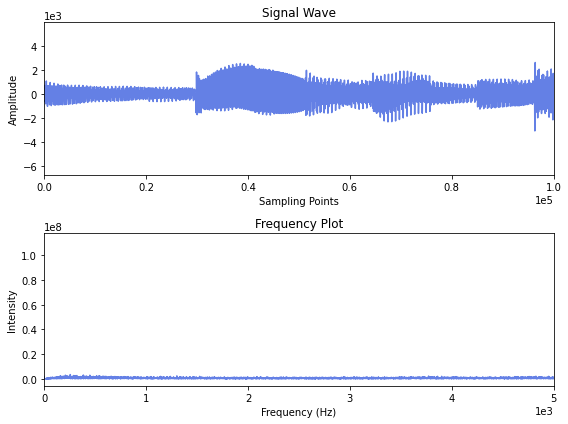

In [3]:
#Load the wav file
wf = wave.open(path + '/' + files[0])
signal = np.fromstring(wf.readframes(-1), 'int16')
#Calculate its spectrum with Fast Fourier Transform algorithm
freqs = fft(signal)

#Ploth both the wave and its spectrum
fig = plt.figure(figsize=(8, 6))
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])

ax1.plot(signal, color="#6480e5")
ax2.plot(np.abs(freqs), color="#6480e5")

ax1.set_title('Signal Wave'), ax2.set_title("Frequency Plot")
ax1.set_xlim([0, 1e5]), ax2.set_xlim([0, 5e3])
# ax1.set_ylim([-4e4, 4e4]), ax2.set_ylim([0, 1.5e8])
ax1.set_xlabel('Sampling Points'), ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude'), ax2.set_ylabel('Intensity') 
ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) 
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()

As expected, the wave composed by a mix of harmonic functions with different frequency, and amplitude. Adding to that, there may be noise and limitations from the recording (it seems for example that the wave amplitude is cut at about 3.2e4, although this doesn't matter to our study). 
This is confirmed by the representation in the frequencies space, where we can observe a number of more or less broad peaks. Some of them fall well beyond the maximum frequency that a guitar string can reach, suggesting that they are indeed external noise. 

At this point we need a way to selectively identify the adequate frequency to associate with the note pitch. The most naïve choice is just to take the frequency with maximum intensity as it is. This assumption is far from ideal, but it is a good starting point for a simple script.

## Identifying the Pitch ##

Here we now define a number of functions that can be used to associate to each file a pitch frequency and subsequently the name of the note.

In particular, to increase the accuracy of our calculation, the maximum frequency is calculated for smaller windows of the recorded wave and then averaged after taking care of removing the extremes, since it appears that at the algorithm is particularly susceptible to noise at the beginning and at the end of the recording (where the wave carrying the fundamental pitch is too weak).  To further improve the result, one could introduce an interpolation of the identified maximum with neighbour frequencies.

In [6]:
#function to find the fundamental pitch frequency
def findFreq(file):
    chunk = 2048 #increasing the size of these chunks can increase the accuracy but at a computational cost
    wf = wave.open(path + '/' + file,'r')
    #we also extract the rate at which the sampling frames were recorded
    #and the total length of the sample
    rate = wf.getframerate()
    swidth = wf.getsampwidth()
    values=[]
    timestep = 1.0/rate #the sampling timestep in seconds
    #now we keep reading the frames contained in each chunk and apply the FFT
    #until we get to the end of the sample
    while True:
        signal = wf.readframes(chunk)
        if len(signal) < chunk*swidth:
            break
        else:
            signal = np.fromstring(signal, 'int16')
            n = signal.size
            #we apply the FFT, extract the frequencies and take their absolute value
            freqs = fft(signal)
            freq = np.fft.fftfreq(n, d=timestep) 
            data = np.abs(freqs)
            #we find the frequency with maximum intensity 
            max = [x for x in argrelextrema(data, np.greater)[0] if x<10000]
            maxInt = data[max]
            absMaxInt=np.max(maxInt)
            absMax=np.where(maxInt==absMaxInt)[0][0]
            number=max[absMax]*rate/chunk
            if number>=minFr and number<=maxFr:
                values.append(number)
    #finally, here we consider only the results from the central part of the signal wave
    #discarding those values that could be affected mostly by noise at the beginnign
    #and at the end of the recording (the value of one third is completely arbitrary)
    l=int(len(values)/3)
    return np.mean(values)	

#function to extract the note from the name of the file
def nameNote(string):
    for el in ["C","D","Elo","Ehi","F","G","A","B"]:
        if el in string:
            return el
    return False	

#function to identify to which string a note belongs:
#since some notes can be produced by different strings, we use information on the plucked string 
#(in the name of the file) when available, otherwise we just assume its the string with 
#highest pitch was chosen;
#this function will be useful to see if the pitch detector functions correctly, since we don't have
#any other information on which note is found in which file,
#in the case of the scale notes, where no information on the string is given, a question mark is left
#although one could try to infer the plucked string somehow
def checkString(note, file):
    notout = ''
    for el in strings:
        if note in strings[el]: 
            if el == nameNote(file): return el
            notout=el
    return notout		

#here we wrap up everything in a single function, that finds frequency, the closest note 
#to the identified frequency and its string
def findNote(file, df):
	results=[]	
#	if nameNote2(file)==False:	return False
	value = findFreq(file)
	MinNote=0
	MinValue=99999
	for index, row in df.iterrows():
		if np.abs(value-row['Freq'])<np.abs(MinValue):
#			if '#' not in row['Note'] and 'b' not in row['Note']:
				MinValue=value-row['Freq']
				MinNote=row['Note']
				MinString=checkString(MinNote,file)
	return MinValue, MinNote, MinString

Applying the Pitch Detector
========================

Now let's see if the algorithm works on our dataset  and plot for each file the difference between the calculated pitch frequency and the ideal frequency of the closest note.

C:\Users\User\AppData\Local\Temp/ipykernel_3744/550831232.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, 'int16')


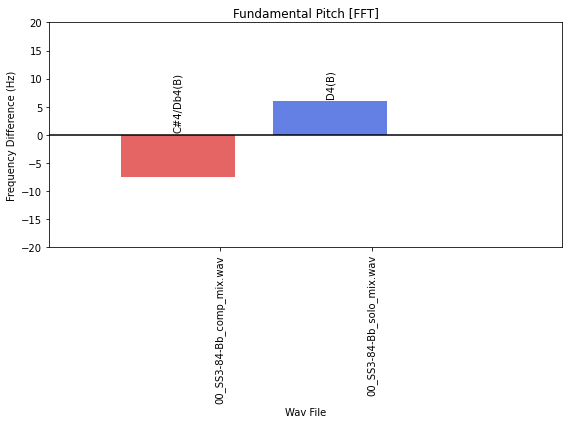

In [7]:
def analysis(files, algo):
    v=[]
    n=[]
    s=[]
    for el in files:
        minValue, minNote, minString = findNote(el,df)
        v.append(minValue)
        n.append(minNote)
        s.append(minString)
    #we save the results in the analysis dataframe    
    dfa[algo+'_Diff']=v
    dfa[algo+'_Not']=n
    dfa[algo+'_Str']=s
    #here we join the note to the identified string in a single word    
    n=[str(a)+'('+str(b)+')' for a,b in zip(n,s)]	
    v=np.array(v)
    
    

    width=0.75
    ind = np.arange(len(files))
    fig = plt.figure(figsize=(8,6))
    gs2 = gridspec.GridSpec(1, 1) 
    ax = fig.add_subplot(gs2[0])

    #we define two masks for our plot, to distinguish the notes that were identified as sharp or flat
    mask1 = v > 0.0
    mask2 = v <= 0.0
    ax.bar(ind[mask1] + width+0.1, v[mask1], width, color='#6480e5')
    ax.bar(ind[mask2] + width+0.1, v[mask2], width, color='#e56464')#
    plt.xticks(ind + width*3/2, files, fontsize=10, rotation='vertical')

    rects = ax.patches
    labels = [n[i] for i in range(len(n)) if mask1[i]]+[n[i] for i in range(len(n)) if mask2[i]]
    v2 = [v[i] for i in range(len(v)) if mask1[i]]+[v[i] for i in range(len(v)) if mask2[i]]

    #now make some labels
    for rect, label, x in zip(rects, labels, v2):
        height = rect.get_height()
        if x<0:
            ax.text(rect.get_x() + rect.get_width()/2, 0.5, label, ha='center', va='bottom', color='black', rotation='vertical')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height + 0.5 , label, ha='center', va='bottom', color='black', rotation='vertical')
    ax.axhline(y=0, color='k')

    plt.xlim([0,len(v)+rects[-1].get_width()])


    ax.set_title('Fundamental Pitch ['+algo+']')
    ax.set_ylim([-20,20])
    ax.set_xlim([0,len(v)+1+width/2])
    ax.set_xlabel('Wav File')
    ax.set_ylabel('Frequency Difference (Hz)') 

    ax.set_aspect("auto")
    plt.tight_layout()
    
analysis(files, 'FFT')

The results are really interesting. The frequencies identified differ from the ideal values of their closest notes by a few Hz maximum, that should indicate that if the guitar is not much out of tune and the noise and spurious frequencies are not affecting the results too much. If the source of these errors were just the tuning of the guitar, however, we would observe that notes belonging to the same string would be all similarly flat or sharp, that is, their values would be consistently under or over the expected note frequency. In theory one could use this knowledge to further clean the dataset and remove the tuning error.

Unfortunately the algorithm as it is doesn't seem to perform that well as some of the files are associated with strings different from those indicated in their names, but it was able to identify a few notes correctly. However, it can be easily improved, first of all by using more sophisticated methods to identify the frequency (may that be through the autocorrelation function or a more accurate analysis of the spectra).  

Now let's see if using other methods can improve or not the results. We will try here the most basic zero crossing and a more accurate algorithm based on autocorrelation. All we need to do is to redefine the function identifying the frequency and reapply the rest to our dataset.

## Zero Crossing ##

This method is the most naïve, it simply counts the distance between points where the wave crosses the zero axis. It is very simple to understand and implement and fairly inexpensive, but don't expect it to be accurate, especially when the harmonic function is far from ideal, due to noise or multiple sources.

C:\Users\User\AppData\Local\Temp/ipykernel_3744/3713699730.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, 'int16')
C:\Users\User\AppData\Local\Temp/ipykernel_3744/3713699730.py:15: RuntimeWarning: divide by zero encountered in short_scalars
  cross = [i - (signal[i] / (signal[i+1] - signal[i])) for i in indices]
C:\Users\User\AppData\Local\Temp/ipykernel_3744/3713699730.py:15: RuntimeWarning: invalid value encountered in short_scalars
  cross = [i - (signal[i] / (signal[i+1] - signal[i])) for i in indices]
C:\Users\User\anaconda3\envs\virtualisation\lib\site-packages\numpy\lib\function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Users\User\AppData\Local\Temp/ipykernel_3744/3713699730.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  good = [x for x in diff if rate/x>=minFr and rate/x<=

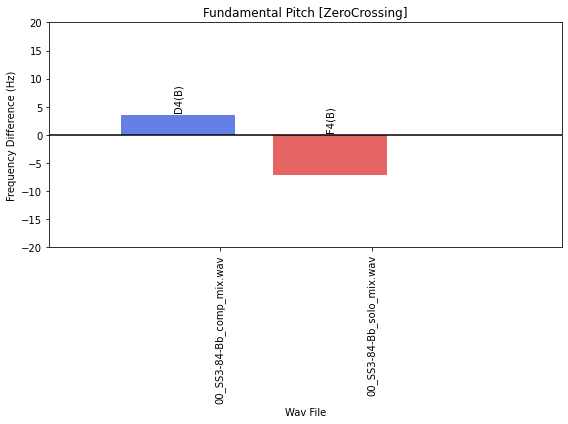

In [9]:
#function to find the fundamental pitch frequency counting zeroes
def findFreq(file):
    wf = wave.open(path + '/' + file,'r')
    signal = wf.readframes(-1)
    signal = np.fromstring(signal, 'int16')
    #one should be careful in deciding if it is worth analysing the entire record or
    #just chunks of it, and excluding more noisy parts  
    #signal=signal[len(signal)/3:len(signal)/2]
    rate = wf.getframerate()
    swidth = wf.getsampwidth()
    #now find the points where the wave crosses the zero axis while rising
    indices = [i for i in range(1,len(signal)) if signal[i-1]<0 and signal[i]>=0]
    #again now we could simply take the indices as they are, or we can interpolate them in different
    #ways to increase the accuracy, here a simple linear interpolation should do the trick
    cross = [i - (signal[i] / (signal[i+1] - signal[i])) for i in indices]
    diff=np.diff(cross)
    #we take only the values that fall within the range of possible guitar notes,
    #but this doesn't save us from including noise that falls within such range 
    good = [x for x in diff if rate/x>=minFr and rate/x<=maxFr]
    return rate / np.mean(good)

analysis(files, 'ZeroCrossing')


As we can se from the graph, the results are no better than those obtained with the Fourier Transform. They are actually slightly worse. The difference in frequency of a few notes is more then 10Hz from their ideal value. Moreover, comparing the results with the information from the file names, we can see that the algorithm is able to identify most of the strings, with the exception of notes in strings Elo and A, it would be interesting to investigate further the source of this discrepancy, since these are the two lowest strings so it seems to suggest that this algorithm is not ideal for low frequency signals. On the other hand, the notes in the Scale dataset are completely off.
From a few tests, it also seems that this method is extremely sensitive to noise. Changing the range of the analysed signal, for example by taking just smaller chunks of the recorded sound waves, affects heavily the results.  

Before drawing any conclusion let's proceed with one final algorithm and see what we obtain.

## Autocorrelation ##

A more refined method requires to analyse the correlation between the function and a shifter version of itself. If the starting function is harmonic, the resulting autocorrelation function will also be harmonic. The method is the most expensive among the ones here shown, and it can be quite accurate, but its still sensitive to noisy signals and can be thrown off by polyphonic sounds, where multiple pitches are present. 


In [11]:
#function to find the fundamental pitch frequency counting zeroes
def findFreq(file):
    wf = wave.open(path + '/' + file,'r')
    signal = wf.readframes(-1)
    signal = np.fromstring(signal, 'int16')
    #one should be careful in deciding if it is worth analysing the entire record or
    #just chunks of it, and excluding more noisy parts  
    #signal=signal[:len(signal)/2]
    rate = wf.getframerate()
    swidth = wf.getsampwidth()
    #first of all we remove the horizontal offset
    signal = signal - np.mean(signal)
    #now we calculate the autocorrelation of the signal against itself but inverted in time
    #and we throw away negative lags
    corr = fftconvolve(signal, signal[::-1], mode='full')
    corr = corr[len(corr)/2:]
    diff = np.diff(corr)
    n = [i for i in range(0,len(diff)) if diff[i]>0][0]
    peak = np.argmax(corr[n:]) + n
    return rate/peak

analysis(files, 'Autocorrelation')

C:\Users\User\AppData\Local\Temp/ipykernel_3744/3986095930.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, 'int16')


TypeError: slice indices must be integers or None or have an __index__ method

The results here are even more interesting, the accuracy of the method is much higher than what observed before, the difference in frequencies is in fact under 5 for all notes with two exceptions. These, (B2.wav and G6.wav) are set to the lowest note in the guitar range and possibly are due to a problem with our algorithm. The frequency ends up being too low, maybe due to noise (but we would observe this effect on more notes) or a bug in the code, which is worth investigating. 

Ignoring for a moment theses two outliers, the results for the remaining notes are fairly satisfying.  The respective strings of each note are often indentified correctly, with the exception of B and Ehi, that contain the highest pitch sounds. This is in line with what found in literature, where it is usually observed that autocorrelation is more efficient at mid to low frequencies. In general it seems that the guitar used to record is slightly flat.

Looking at the Scale files, the algorithm correctly recognises the ascending order of the notes, but for some reason there seems to be an offset of two notes lower, Do is seen as an A2 instead of, possibly a C3, Re as a B2 instead of a D3 and so on and so forth. This may be symptom of a systematic error in our algorithm, (maybe in the assignment of the notes). Most likely, the Scale was played on the A string (here some of the notes are labelled as belonging to the D string due to our choice to always choose the string with highest pitch when in doubt) or on both Elo and A, starting from C3 onward.

## Comparison ##

Now let's do a quick comparison of the three algorithms exploiting the little information available from the file names.

In [ ]:
#We loaded all the ouptut data of the three algorithms in this dataframe, now let's add
#the information from the file names
def nameNoteFile(string):
    conversion = {"Do" : "C",
        "Re" : "D",
         "Mi" : "E",
        "Fa" : "F",
        "So" : "G",
        "La" : "A",
        "Ti" : "B"}
    for el in ["Do","Re","Mi","Fa","So","La","Ti"]:
        if el in string:
            return conversion[el]
    return False

def noteReal(x):
    if 'Scale' in x: return nameNoteFile(x)
    else: return ''

def stringReal(x):
    if 'Scale' in x: return ''
    else: return nameNote(x)
    
dfa['Real_Not'] = dfa.apply(lambda x: noteReal(x['File']), axis=1)
dfa['Real_Str'] = dfa.apply(lambda x: stringReal(x['File']), axis=1)

#Now let's have a look at the dataframe
dfa

In [ ]:
#And now we calculate a few useful quantities

#Here we could check how many notes in the scale have been correctly predicted, but
#it doesn't tell us much since we have only 5 files
dfa['FFT_NotCount'] = np.where(dfa['Real_Not']==dfa['FFT_Not'].str[0], np.where('#' in dfa['FFT_Not'], 1, 0), 0)  
dfa['ZeroCrossing_NotCount'] = np.where(dfa['Real_Not']==dfa['ZeroCrossing_Not'].str[0], 1, 0)
dfa['Autocorrelation_NotCount'] = np.where(dfa['Real_Not']==dfa['Autocorrelation_Not'].str[0], 1, 0)

#Here we check the number of strings correctly predicted
dfa['FFT_StrCount'] = np.where(dfa['Real_Str']==dfa['FFT_Str'], 1, 0)
dfa['ZeroCrossing_StrCount'] = np.where(dfa['Real_Str']==dfa['ZeroCrossing_Str'], 1, 0)
dfa['Autocorrelation_StrCount'] = np.where(dfa['Real_Str']==dfa['Autocorrelation_Str'], 1, 0)

print('RESULTS')
print('==========================================\n')
print('FFT Scale Notes Prediction: '+'{:.0f}'.format(dfa['FFT_NotCount'][:5].sum()*100/dfa['FFT_NotCount'][:5].count())+'%')
print('FFT Strings Notes Prediction: '+'{:.0f}'.format(dfa['FFT_StrCount'][5:].sum()*100/dfa['FFT_StrCount'][5:].count())+'%')
print('FFT Mean Frequency Difference: '+'{:.2f}'.format(dfa['FFT_Diff'].abs().mean()) + ' Hz\n')
print('Zero Crossing Scale Notes Prediction: '+'{:.0f}'.format(dfa['ZeroCrossing_NotCount'][:5].sum()*100/dfa['ZeroCrossing_NotCount'][:5].count())+'%')
print('Zero Crossing Strings Notes Prediction: '+'{:.0f}'.format(dfa['ZeroCrossing_StrCount'][5:].sum()*100/dfa['ZeroCrossing_StrCount'][5:].count())+'%')
print('Zero Crossing Mean Frequency Difference: '+'{:.2f}'.format(dfa['ZeroCrossing_Diff'].abs().mean()) + ' Hz\n')
print('Autocorrelation Scale Notes Prediction: '+'{:.0f}'.format(dfa['Autocorrelation_NotCount'][:5].sum()*100/dfa['Autocorrelation_NotCount'][:5].count())+'%')
print('Autocorrelation Strings Notes Prediction: '+'{:.0f}'.format(dfa['Autocorrelation_StrCount'][5:].sum()*100/dfa['Autocorrelation_StrCount'][5:].count())+'%')
print('Autocorrelation Mean Frequency Difference: '+'{:.2f}'.format(dfa['Autocorrelation_Diff'].abs().mean()) + ' Hz\n')

So, as already mentioned, zero crossing gives the poorest results, with a string note prediction slightly lower than the other two methods (especially in low frequency regions of the spectrum), and a relatively high mean difference between the measured frequencies and the predicted notes.
On the other hand, although still unable to predict notes perfectly (but the scale is there!), the algorithm based on autocorrelation gives the best results by far, with a very low mean frequency difference (less then a Hertz) and high string predictions. From our results, this methods is less effective at higher frequencies and seems to be affected by a systematic error in the note recognition snippet that should be investigated.
Finally, the algorithm based on the Fourier Transform is halfway between the other two, with a string prediction similar to that of the autocorrelation method, but an higher mean frequency difference.

In this notebook, the three algorithms have been implemented in a straightforward and naïve way, giving us the chance to observe their different properties and efficacy on the available dataset. Refining their implementation and pre-processing of the sound waves files, to either remove or identify possible sources of noise, however, could easily improve the results and give a more accurate pitch detector.